<a href="https://colab.research.google.com/github/Holmes-Alan/ImageNet_sample/blob/main/Simple_CNN_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python3 --version

Python 3.10.12


In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [3]:
import torch
import torchvision

In [4]:
!git clone https://github.com/Holmes-Alan/ImageNet_sample.git

Cloning into 'ImageNet_sample'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 15 (delta 1), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (15/15), 936.76 KiB | 10.53 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [5]:
import torch
from torchvision import models
model = models.alexnet(pretrained=True)
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 126MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [6]:
!pwd

/content


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


The best prediction:

'/content/ImageNet_sample/polar_bear.jpg': 99.87644958496094% is a 'ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus'

Top 5 prediction:

99.87644958496094% is a 'ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus'
0.1013692319393158% is a 'white wolf, Arctic wolf, Canis lupus tundrarum'
0.01934994012117386% is a 'Arctic fox, white fox, Alopex lagopus'
0.0025697106029838324% is a 'Samoyed, Samoyede'
0.00015759243979118764% is a 'kuvasz'


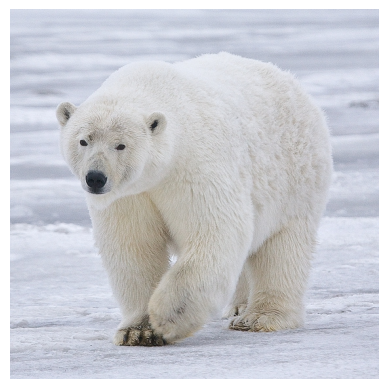

In [7]:
# sample execution (requires torchvision)
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

filename = '/content/ImageNet_sample/polar_bear.jpg'

input_image = Image.open(filename)
plt.imshow(input_image)
plt.axis('off')

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)

# normalize the output as probability
percentage = torch.nn.functional.softmax(output, dim=1)[0] * 100

# Load Imagenet Synsets
with open('/content/ImageNet_sample/imagenet_synsets.txt', 'r') as f:
    synsets = f.readlines()

# len(synsets)==1001
# sysnets[0] == background
synsets = [x.strip() for x in synsets]
splits = [line.split(' ') for line in synsets]
key_to_classname = {spl[0]:' '.join(spl[1:]) for spl in splits}

with open('/content/ImageNet_sample/imagenet_classes.txt', 'r') as f:
    class_id_to_key = f.readlines()

class_id_to_key = [x.strip() for x in class_id_to_key]

print('The best prediction:\n')
_, index = torch.max(output, 1)
classname = key_to_classname[class_id_to_key[index[0]]]
probability = percentage[index[0]].item()
print("'{}': {}% is a '{}'".format(filename, probability, classname))

print('\nTop 5 prediction:\n')
_, indices = torch.sort(output, descending=True)
for idx in indices[0][:5]:
    print("{}% is a '{}'".format(percentage[idx].item(), key_to_classname[class_id_to_key[idx]]))